# Book Recommender System With Keras 

In [92]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns #for visualisation



In [93]:
dataset = pd.read_csv('Dataset/ratings.csv')

dataset.drop_duplicates(inplace=True) #Drop duplicate entries


print('we have',dataset.shape[0], 'ratings')
dataset.head()

we have 980112 ratings


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


**Load the books list**

In [94]:
books_df = pd.read_csv('Dataset/books.csv')
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


**Visualising the number of ratings per book: -**

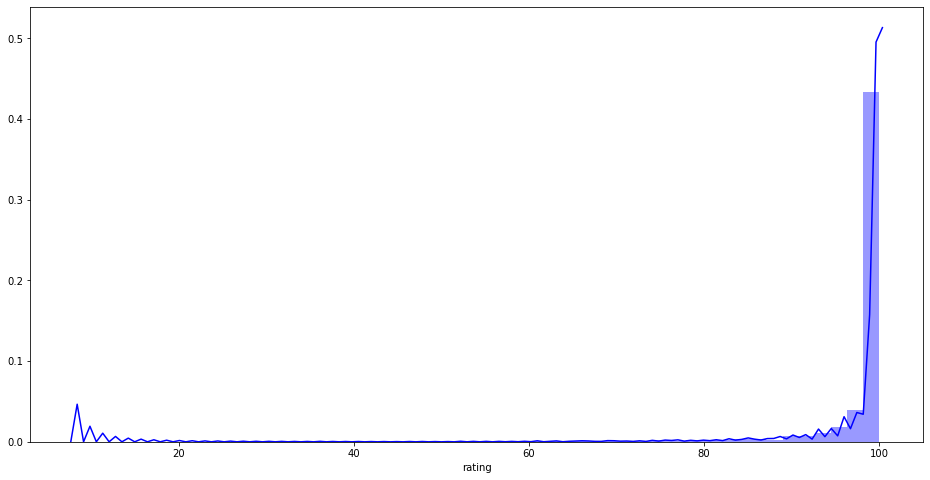

In [110]:
no_of_ratings_per_book=dataset.groupby('book_id').count()
plt.figure(figsize=(16,8))
sns.distplot(a=no_of_ratings_per_book['rating'], color='b')

**The user_id and book_id in the dataset is currently non-sequential, it is required to convert them into sequential (starting from zero). Scikit-learn’s LabelEncoder class helps to transform the fields.**

In [111]:
#user
user_enc = LabelEncoder()
dataset['user'] = user_enc.fit_transform(dataset['user_id'].values)
n_users = dataset['user'].nunique()

#book
item_enc = LabelEncoder()
dataset['book'] = item_enc.fit_transform(dataset['book_id'].values)
n_books = dataset['book'].nunique()

dataset['rating'] = dataset['rating'].values.astype(np.float32) 

min_rating = min(dataset['rating'])
max_rating = max(dataset['rating'])

print('the number of unique users we have is:', n_users)
print('the number of unique books we have is:', n_books)
print("The median user rated %d books."%dataset.user_id.value_counts().median())
print('The max rating is: %d'%min_rating,"the min rating is: %d"%max_rating)
dataset.tail()


the number of unique users we have is: 53424
the number of unique books we have is: 10000
The median user rated 8 books.
The max rating is: 1 the min rating is: 5


,book_id,user_id,rating,user,book
981751,10000,48386,5.0,48385,9999
981752,10000,49007,4.0,49006,9999
981753,10000,49383,5.0,49382,9999
981754,10000,50124,5.0,50123,9999
981755,10000,51328,1.0,51327,9999


**Split into training and test sets, with an 80-20 split.**

In [112]:
X = dataset[['user', 'book']].values
y = dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((784089, 2), (196023, 2), (784089,), (196023,))

In [113]:
n_factors = 20 #No of factors per user/book (A hyperparameter)
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

**Define the model.**

In [114]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
def RecommenderNet(n_users, n_books, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    book = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(book)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [100]:
model = RecommenderNet(n_users, n_books, n_factors)
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 20)        1068480     input_14[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 20)        200000      input_15[0][0]                   
_______________________________________________________________________________________

In [101]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


12252/12252 [==============================] - 108s 9ms/step - loss: 11.0717 - val_loss: 4.0073
Epoch 2/5
12252/12252 [==============================] - 108s 9ms/step - loss: 2.2642 - val_loss: 1.7503
Epoch 3/5
12252/12252 [==============================] - 108s 9ms/step - loss: 1.3394 - val_loss: 1.4632
Epoch 4/5
12252/12252 [==============================] - 107s 9ms/step - loss: 1.1592 - val_loss: 1.3911
Epoch 5/5
12252/12252 [==============================] - 107s 9ms/step - loss: 1.0971 - val_loss: 1.3752


**Taking a look at the model perfomance, it has performed decently well. More epochs would only cause the model to overfit.**

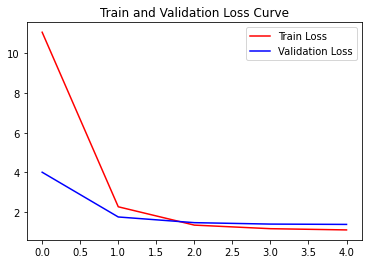

In [115]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

**The *embedding* layer can be extracted and visalised.**

In [117]:
book_em = model.get_layer('embedding_12')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(53424, 20)

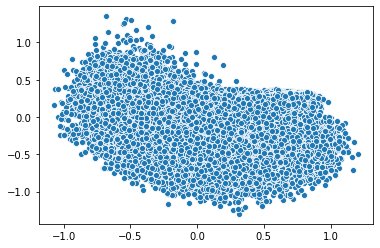

In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

# Making Recommendations

**We can use the model to predict the top 10 recommendations for a user**

In [119]:
#Making recommendations for user 8000
user_r = 8000
b_id =list(dataset.book_id.unique())
book_arr = np.array(b_id) #get all book IDs
user = np.array([user_r for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[1.0547988 ],
       [0.24974018],
       [0.7680735 ],
       ...,
       [0.46402448],
       [0.86933964],
       [2.3035917 ]], dtype=float32)

In [120]:
pred = pred.reshape(-1) #reshape to single dimension

pred_ids = (-pred).argsort()[0:10]
pred_ids

array([7940, 9898, 9542, 7699, 7119, 6737, 9170, 8772, 7525, 1400])

In [121]:
top10 = books_df.iloc[pred_ids]
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [109]:
from IPython.display import Image, HTML

def path_to_image_html(path):
    return '<img src="'+ path + '""/>'

HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html),justify='center'))

,small_image_url
title,
"The Last Detective (Elvis Cole, #9)",
"Grit: Passion, Perseverance, and the Science of Success",
"Disastrous (Disastrous, #1)",
"Taken by Midnight (Midnight Breed, #8)",
"The Dark Forest (Remembrance of Earth’s Past, #2)",
"The Hedge Knight (The Hedge Knight Graphic Novels, #1)",
"Faking It (Dempseys, #2)",
Breaking Free: Discover the Victory of Total Surrender,
No Talking,
